![Python Logo](./img/python-logo-master-v3-TM-flattened_small.png)

# Financial Programming - IÉSEG, Lille - MBD 2020-2021
## Group Project - Financial Data

### Data Exploration

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Input data**

In [3]:
# Each record describes static characteristics of an account
account = pd.read_csv('./data_berka/account.asc', sep=';')
account = account.rename(columns={'date':'account_date'})
account['account_date'] = pd.to_datetime('19' + account['account_date'].astype(str), format='%Y%m%d')
account['frequency']= account['frequency'].map({'POPLATEK MESICNE': 'monthly issuance', 
                                                      'POPLATEK TYDNE': 'weekly issuance', 
                                                      'POPLATEK PO OBRATU': 'issuance after transaction'})
account.head()

,account_id,district_id,frequency,account_date
0,576,55,monthly issuance,1993-01-01
1,3818,74,monthly issuance,1993-01-01
2,704,55,monthly issuance,1993-01-01
3,2378,16,monthly issuance,1993-01-01
4,2632,24,monthly issuance,1993-01-02


In [4]:
# Each record describes a credit card issued to an account
card = pd.read_csv('./data_berka/card.asc', sep=';')
card = card.rename(columns={'type':'card_type'})
card[['date', 'minutes']] = card['issued'].str.split(" ",expand=True,)
card = card.drop(columns =['minutes'])
card['issued'] = pd.to_datetime('19' + card['date'].astype(str), format='%Y%m%d')
card = card.drop(columns =['date'])
card.head()

,card_id,disp_id,card_type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15


In [5]:
# Each record describes characteristics of a client
client = pd.read_csv('./data_berka/client.asc', sep=';')
client['birth_year'] = client['birth_number'].transform(lambda bn: int('19' + str(bn)[:2]))
client['birth_day'] = client['birth_number'].astype(str).str[-2:].astype(int)
client['age'] = 1999-client['birth_year']
client['decade_age'] = ((client['age'] // 10) *10 ).astype(str) + "-" + ((client['age'] // 10) *10 +10 ).astype(str)
client.head()

,client_id,birth_number,district_id,birth_year,birth_day,age,decade_age
0,1,706213,18,1970,13,29,20-30
1,2,450204,1,1945,4,54,50-60
2,3,406009,1,1940,9,59,50-60
3,4,561201,5,1956,1,43,40-50
4,5,605703,5,1960,3,39,30-40


In [6]:
def to_month_gender(birth_number):
    
    s = str(birth_number)
    birth_month = int(s[2:4])
    
    if birth_month > 50:
        gender = "F"
        birth_month = birth_month - 50
    else:
        gender = 'M'
        
    return pd.Series({'birth_month':birth_month, 'gender':gender})

client[['birth_month', 'gender']] = client['birth_number'].apply(to_month_gender)
client['birthdate'] =  client['birth_year'].astype(str) + client['birth_month'].astype(str) + client['birth_day'].astype(str)
client['birthdate'] = pd.to_datetime(client['birthdate'].astype(str), format='%Y%m%d')
client = client.drop(columns=['birth_year', 'birth_day', 'birth_month', 'birth_number'])
client.head()

,client_id,district_id,age,decade_age,gender,birthdate
0,1,18,29,20-30,F,1970-12-13
1,2,1,54,50-60,M,1945-02-04
2,3,1,59,50-60,F,1940-10-09
3,4,5,43,40-50,M,1956-12-01
4,5,5,39,30-40,F,1960-07-03


In [7]:
# Each record relates together a client with an account i.e. this relation describes the rights
# of clients to operate accounts
disp = pd.read_csv('./data_berka/disp.asc', sep=';')
disp = disp.rename(columns={'type':'disp_type'})
disp.head()

,disp_id,client_id,account_id,disp_type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [8]:
# Each record describes characteristics of a payment order
order = pd.read_csv('./data_berka/order.asc', sep=';')
order = order.rename(columns={'amount':'order_amount', 'k_symbol':'order_k_symbol'})
order['order_k_symbol']= order['order_k_symbol'].map({'POJISTNE': 'insurrance payment', 
                                                      'SIPO': 'household payment', 
                                                      'LEASING': 'leasing', 
                                                      'UVER': 'loan payment', np.NaN: 'Unknown'})
order1 = order
order = order.pivot_table('order_amount', 'account_id', ['order_k_symbol'])
order = pd.DataFrame(order.to_records())
order

,account_id,household payment,insurrance payment,leasing,loan payment
0,1,2452.0,NaN,NaN,NaN
1,2,7266.0,NaN,NaN,3372.7
2,3,1135.0,3539.0,NaN,NaN
3,4,1681.5,NaN,NaN,NaN
4,5,2668.0,NaN,NaN,NaN
...,...,...,...,...,...
3753,11328,NaN,NaN,NaN,4674.0
3754,11333,NaN,NaN,3286.7,NaN
3755,11349,10886.0,NaN,NaN,6998.0
3756,11359,4518.0,NaN,NaN,4502.3


In [9]:
# Each record describes one transaction on an account
trans = pd.read_csv('./data_berka/trans.asc', sep=';', low_memory=False)
trans[trans['type'] == 'VYBER']['operation'].unique()
trans = trans.rename(columns={'amount':'trans_amount'})
trans = trans.rename(columns={'type':'trans_type'})
trans = trans.rename(columns={'date':'trans_date', 'k_symbol': 'trans_k_symbol'})
#trans = trans.dropna(0)
trans['trans_date'] = pd.to_datetime('19' + trans['trans_date'].astype(str), format='%Y%m%d')

trans['operation'] = trans['operation'].map({'VKLAD': 'credit in cash', 
                                             'VYBER KARTOU': 'credit card withdrawal', 
                                             'PREVOD Z UCTU': 'collection from another bank', 
                                             'VYBER':'withdrawal in cash', 'PREVOD NA UCET': 'remittance to another bank' })

trans['trans_type'] = trans['trans_type'].map({'PRIJEM': 'credit', 
                                             'VYDAJ': 'withdrawal'})

trans['trans_k_symbol'] = trans['trans_k_symbol'].map({'POJISTNE': 'insurrance payment', 
                                                       'SLUZBY': 'payment for statement', 
                                                       'UROK':'interest credited', 
                                                       'SANKC. UROK':'interest if negative balance', 
                                                       'SIPO': 'household', 
                                                       'DUCHOD': 'old-age pension', 
                                                       'UVER': 'loan payment', np.NaN: 'unknown' })

trans_data = trans
trans.head()

,trans_id,account_id,trans_date,trans_type,operation,trans_amount,balance,trans_k_symbol,bank,account
0,695247,2378,1993-01-01,credit,credit in cash,700.0,700.0,unknown,NaN,NaN
1,171812,576,1993-01-01,credit,credit in cash,900.0,900.0,unknown,NaN,NaN
2,207264,704,1993-01-01,credit,credit in cash,1000.0,1000.0,unknown,NaN,NaN
3,1117247,3818,1993-01-01,credit,credit in cash,600.0,600.0,unknown,NaN,NaN
4,579373,1972,1993-01-02,credit,credit in cash,400.0,400.0,unknown,NaN,NaN


In [10]:
#trans.sort_values('trans_date').groupby('account_id').tail(1)
trans_last_balance = trans.sort_values(by="trans_date").drop_duplicates(subset=["account_id"], keep="last")
trans_last_balance = trans_last_balance[['account_id', 'trans_date', 'balance']]
trans_last_balance = trans_last_balance.rename(columns={'trans_date':'_trans_date'})
trans_last_balance

,account_id,_trans_date,balance
369246,799,1996-08-25,9348.3
378587,1720,1996-09-07,11400.0
433290,2029,1996-12-09,8900.0
501925,459,1997-03-01,8100.0
507351,2180,1997-03-10,11300.0
...,...,...,...
1053316,2990,1998-12-31,42712.1
1053315,3025,1998-12-31,15933.6
1053314,3053,1998-12-31,86982.1
1053320,3077,1998-12-31,68530.7


In [11]:
trans_first_balance = trans.sort_values(by="trans_date").drop_duplicates(subset=["account_id"], keep="first")
trans_first_balance = trans_first_balance[['account_id', 'trans_date']]
trans_first_balance = trans_first_balance.rename(columns={'trans_date':'first_trans_date'})

trans_date_and_balance = pd.merge(trans_first_balance, trans_last_balance, how= 'inner', on = 'account_id')
trans_date_and_balance = pd.DataFrame(trans_date_and_balance.to_records())
trans_date_and_balance = trans_date_and_balance.drop(columns=['index'])
trans_date_and_balance

,account_id,first_trans_date,_trans_date,balance
0,2378,1993-01-01,1998-12-31,93349.5
1,576,1993-01-01,1998-12-31,35550.7
2,704,1993-01-01,1998-12-31,81680.3
3,3818,1993-01-01,1998-12-31,62199.8
4,1972,1993-01-02,1998-12-31,23740.2
...,...,...,...,...
4495,777,1997-12-28,1998-12-31,70547.3
4496,124,1997-12-28,1998-12-31,13566.0
4497,3958,1997-12-28,1998-12-31,52391.3
4498,1573,1997-12-29,1998-12-31,12963.1


In [12]:
trans1 = trans.pivot_table('trans_amount', 'account_id', ['operation'])
trans1 = pd.DataFrame(trans1.to_records())
trans2 = trans.pivot_table('trans_amount', 'account_id', ['trans_k_symbol'])
trans2 = pd.DataFrame(trans2.to_records())
trans3 = trans.pivot_table('trans_amount', 'account_id', ['trans_type'])
trans3 = pd.DataFrame(trans3.to_records())
trans_merged = pd.merge(trans1, trans2, how= 'inner', on = 'account_id')
trans_merged = pd.merge(trans_merged, trans3, how= 'inner', on = ['account_id'])
#trans_merged['test'] = trans_merged['credit'] - trans_merged['withdrawal']
trans_merged = pd.merge(trans_merged, trans_date_and_balance, how= 'inner', on = 'account_id')
trans_merged.head()

,account_id,collection from another bank,credit card withdrawal,credit in cash,remittance to another bank,withdrawal in cash,household,insurrance payment,interest credited,interest if negative balance,loan payment,old-age pension,payment for statement,unknown,credit,withdrawal,first_trans_date,_trans_date,balance
0,1,3679.000000,NaN,2141.666667,2452.000000,853.340206,2452.0,NaN,68.122222,NaN,NaN,NaN,14.6,2398.640351,1905.102941,1320.102190,1995-03-24,1998-12-31,13466.5
1,2,21970.514286,NaN,4033.333333,6216.121348,4224.434599,7266.0,NaN,153.107143,NaN,3372.7,NaN,14.6,10183.377953,10506.930921,4383.553443,1993-02-26,1998-12-31,42628.1
2,3,NaN,NaN,6106.750000,1667.000000,1779.681250,1135.0,3539.0,115.000000,NaN,NaN,NaN,14.6,4845.723404,3762.152174,1717.785915,1997-07-07,1998-12-31,51096.1
3,4,5553.000000,NaN,800.000000,1674.779661,964.732258,2078.0,NaN,91.466667,NaN,NaN,5553.0,14.6,1770.294118,2959.169231,1310.953719,1996-02-21,1998-12-31,33720.7
4,5,5017.000000,NaN,600.000000,2668.000000,915.554286,2668.0,NaN,104.133333,NaN,NaN,5017.0,14.6,1474.545455,2785.285714,1416.253061,1997-05-30,1998-12-31,28088.3


In [13]:
# Each record describes a loan granted for a given account
loan = pd.read_csv('./data_berka/loan.asc', sep=';')
loan = loan.rename(columns={'amount':'loan_amount'})
loan = loan.rename(columns={'date':'loan_date'})
loan['loan_date'] = pd.to_datetime('19' + loan['loan_date'].astype(str), format='%Y%m%d')
loan.head()

,loan_id,account_id,loan_date,loan_amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [14]:
loan_meaning = []
loan_client_type = []

for i in loan['status']:
    if i == 'A':
        loan_meaning.append('Finished, no issues')
        loan_client_type.append('Good Client')
    elif i == 'C':
        loan_meaning.append('Ok so far')
        loan_client_type.append('Good Client')
    elif i == 'B':
        loan_meaning.append('Finished, loan not paid')
        loan_client_type.append('Bad Client')
    elif i == 'D':
        loan_meaning.append('Running contract, client in debt')
        loan_client_type.append('Bad Client')
    else:
        loan_meaning.append('')
        loan_client_type.append('')
        
loan['loan_meaning']= loan_meaning
loan['loan_client_type'] =loan_client_type
loan.head()

,loan_id,account_id,loan_date,loan_amount,duration,payments,status,loan_meaning,loan_client_type
0,5314,1787,1993-07-05,96396,12,8033.0,B,"Finished, loan not paid",Bad Client
1,5316,1801,1993-07-11,165960,36,4610.0,A,"Finished, no issues",Good Client
2,6863,9188,1993-07-28,127080,60,2118.0,A,"Finished, no issues",Good Client
3,5325,1843,1993-08-03,105804,36,2939.0,A,"Finished, no issues",Good Client
4,7240,11013,1993-09-06,274740,60,4579.0,A,"Finished, no issues",Good Client


In [15]:
len(loan.loan_amount)

682

In [16]:
loan_size = []

for i in loan['loan_amount']:
    if i < 50000:
        loan_size.append('0-50000')
    elif 50000 < i < 100000:
        loan_size.append('50000-100000')
    elif 100000 < i < 150000:
        loan_size.append('100000-150000')
    elif 150000 < i < 200000:
        loan_size.append('150000-200000')
    elif 200000 < i < 250000:
        loan_size.append('200000-250000')
    elif 250000 < i < 300000:
        loan_size.append('250000-300000')
    elif 300000 < i < 350000:
        loan_size.append('300000-350000')
    elif 350000 < i < 400000:
        loan_size.append('350000-400000')
    elif 400000 < i < 450000:
        loan_size.append('400000-450000')
    elif 450000 < i < 500000:
        loan_size.append('450000-500000')
    else:
        loan_size.append('>500000')
        
loan['loan_size'] = loan_size
loan

,loan_id,account_id,loan_date,loan_amount,duration,payments,status,loan_meaning,loan_client_type,loan_size
0,5314,1787,1993-07-05,96396,12,8033.0,B,"Finished, loan not paid",Bad Client,50000-100000
1,5316,1801,1993-07-11,165960,36,4610.0,A,"Finished, no issues",Good Client,150000-200000
2,6863,9188,1993-07-28,127080,60,2118.0,A,"Finished, no issues",Good Client,100000-150000
3,5325,1843,1993-08-03,105804,36,2939.0,A,"Finished, no issues",Good Client,100000-150000
4,7240,11013,1993-09-06,274740,60,4579.0,A,"Finished, no issues",Good Client,250000-300000
...,...,...,...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,C,Ok so far,Good Client,350000-400000
678,5221,1284,1998-12-05,52512,12,4376.0,C,Ok so far,Good Client,50000-100000
679,6402,6922,1998-12-06,139488,24,5812.0,C,Ok so far,Good Client,100000-150000
680,5346,1928,1998-12-06,55632,24,2318.0,C,Ok so far,Good Client,50000-100000


In [19]:
# Each record describes demographic characteristics of a district.
district = pd.read_csv('./data_berka/district.asc', sep=';')
district = district.rename(columns={'A1':'district_id','A2':'district_name', 'A3':'region', 'A4':'no_inhabitants', 'A5':'no_inhabitants<499'})
district = district.rename(columns={'A6':'no_inhabitants500-1999','A7':'no_inhabitants2000-9999','A8':'no_inhabitants>10000'})
district = district.rename(columns={'A9':'no_cities','A10':'ratio of urban inhabitants', 'A11':'average salary' })
district = district.rename(columns={'A12':'unemploymant rate95','A13':'unemploymant rate96', 'A14':'no. of enterpreneurs per 1000 inhabitants'})
district = district.rename(columns={'A15':'no. of commited crimes95','A16':'no. of commited crimes96'})

district['unemploymant rate95'] = district['unemploymant rate95'].replace('?',np.nan)
district['unemploymant rate96'] = district['unemploymant rate96'].replace('?',np.nan)


district.head()

,district_id,district_name,region,no_inhabitants,no_inhabitants<499,no_inhabitants500-1999,no_inhabitants2000-9999,no_inhabitants>10000,no_cities,ratio of urban inhabitants,average salary,unemploymant rate95,unemploymant rate96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes95,no. of commited crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [20]:
trans.head()

,trans_id,account_id,trans_date,trans_type,operation,trans_amount,balance,trans_k_symbol,bank,account
0,695247,2378,1993-01-01,credit,credit in cash,700.0,700.0,unknown,NaN,NaN
1,171812,576,1993-01-01,credit,credit in cash,900.0,900.0,unknown,NaN,NaN
2,207264,704,1993-01-01,credit,credit in cash,1000.0,1000.0,unknown,NaN,NaN
3,1117247,3818,1993-01-01,credit,credit in cash,600.0,600.0,unknown,NaN,NaN
4,579373,1972,1993-01-02,credit,credit in cash,400.0,400.0,unknown,NaN,NaN


In [21]:
database = pd.merge(disp, card,  how='outer', on=['disp_id'])
database = pd.merge(client, database,  how='outer', on=['client_id'])
database = pd.merge(database, account,  how='outer', on=['account_id', 'district_id'])
database = pd.merge(database, district,  how='outer', on=['district_id'])
database = pd.merge(database, trans_merged,  how='outer', on=['account_id'])
database = pd.merge(database, loan,  how='outer', on=['account_id'])
database = pd.merge(database, order,  how='outer', on=['account_id'])
database

,client_id,district_id,age,decade_age,gender,birthdate,disp_id,account_id,disp_type,card_id,...,duration,payments,status,loan_meaning,loan_client_type,loan_size,household payment,insurrance payment_y,leasing,loan payment_y
0,1.0,18,29.0,20-30,F,1970-12-13,1.0,1,OWNER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2452.0,NaN,NaN,NaN
1,420.0,18,21.0,20-30,M,1978-03-13,420.0,343,OWNER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2505.0,NaN,NaN,NaN
2,499.0,18,64.0,60-70,F,1935-07-08,499.0,413,OWNER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2107.0,NaN,NaN,NaN
3,519.0,18,19.0,10-20,M,1980-04-13,519.0,431,OWNER,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6482.0,NaN,NaN,NaN
4,682.0,18,20.0,20-30,M,1979-10-21,682.0,568,OWNER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1408.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,9930.0,9,27.0,20-30,M,1972-06-23,9622.0,8039,OWNER,1024.0,...,24.0,3900.0,A,"Finished, no issues",Good Client,50000-100000,1074.0,3231.0,NaN,3900.5
5774,10070.0,9,25.0,20-30,M,1974-04-23,9762.0,8153,OWNER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993.6,NaN
5775,11266.0,9,61.0,60-70,M,1938-09-25,10958.0,9153,OWNER,NaN,...,36.0,1451.0,C,Ok so far,Good Client,50000-100000,5042.0,NaN,NaN,1451.0
5776,11267.0,9,63.0,60-70,F,1936-08-26,10959.0,9153,DISPONENT,NaN,...,36.0,1451.0,C,Ok so far,Good Client,50000-100000,5042.0,NaN,NaN,1451.0


In [22]:
database['unemploymant rate95'] = pd.to_numeric(database['unemploymant rate95'])

OBJECTIVE: 
    - What is a good client or a bad client ? 
        --> Based our explanation on the loan result (repyament or not)
        --> Good client = Positive balance + loan payed + no interest on negative balance 
        --> Bad client = Opposite 
1) Data manipulation 
2) General description of the customers 
3) Loan Analysis 
    ** histogram = Customer balance impact on the loan - important to say that learn that people 
    with balance negative or next to should'nt have a loan because in the past they never pay back. 
4) Credit scoring : 
    Principal output : we advise the bank with a ranking to the best client to give a loan to the worst 
        With this table, the bank can apply a different interest rate depending on the ranking position
        10 variables impacts the ranking with positive or negative correlations

## Customer description 

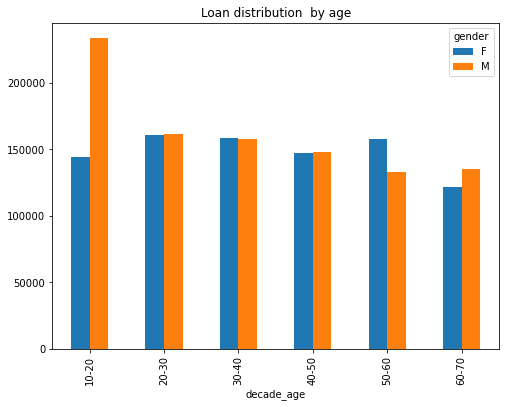

In [23]:
loan_distribution = database.pivot_table('loan_amount', 'decade_age', 'gender').plot.bar(title = 'Loan distribution  by age', figsize=(8, 6))

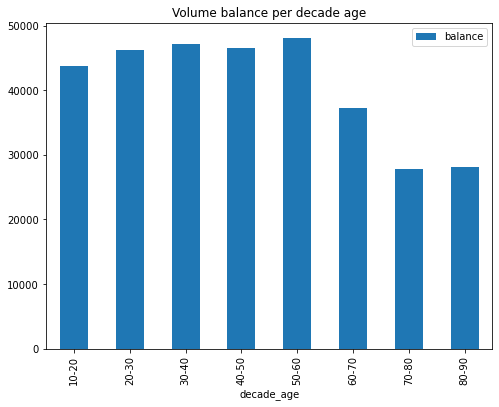

In [24]:
database.pivot_table('balance', 'decade_age').plot.bar(title = 'Volume balance per decade age', figsize=(8, 6))

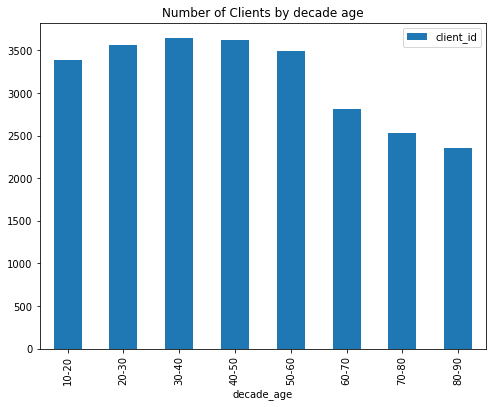

In [25]:
database.pivot_table('client_id', 'decade_age').plot.bar(title = 'Number of Clients by decade age', figsize=(8, 6))

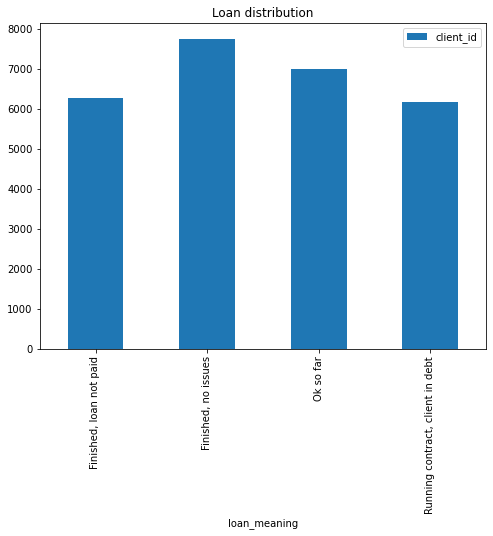

In [26]:
database.pivot_table('client_id', 'loan_meaning').plot.bar(title = 'Loan distribution', figsize=(8, 6))

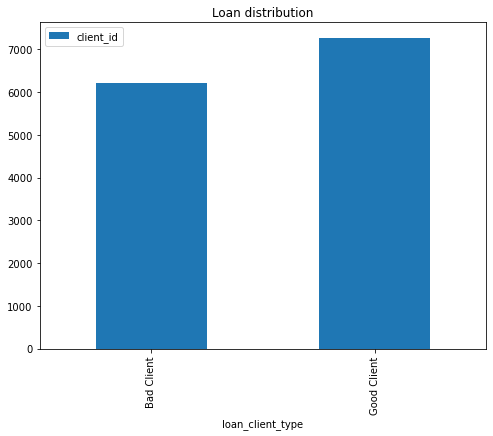

In [27]:
database.pivot_table('client_id', 'loan_client_type').plot.bar(title = 'Loan distribution', figsize=(8, 6))

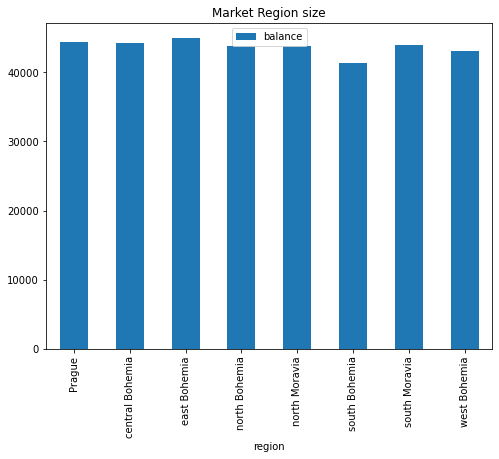

In [28]:
loan_district_distribution = database.pivot_table('balance', 'region').plot.bar(title = 'Market Region size', figsize=(8, 6))

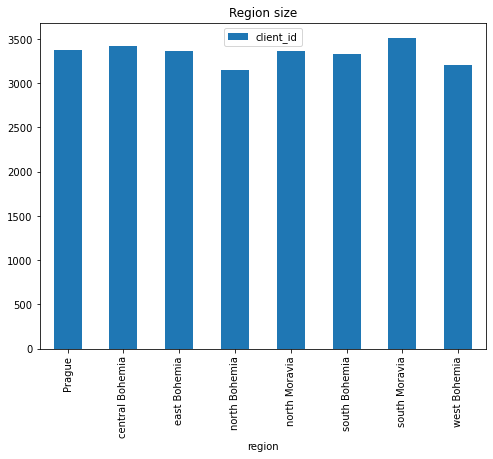

In [29]:
loan_district_distribution = database.pivot_table('client_id', 'region').plot.bar(title = 'Region size', figsize=(8, 6))

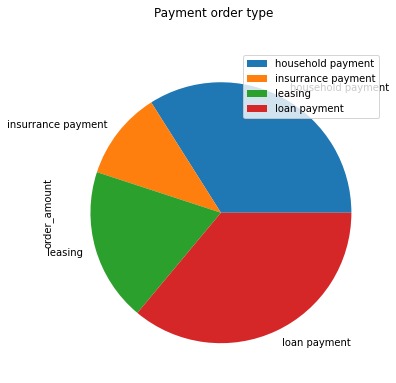

In [30]:
payment_characterization_order = order1.pivot_table('order_amount', 'order_k_symbol').plot.pie(title = 'Payment order type', subplots=True, figsize=(8, 6))

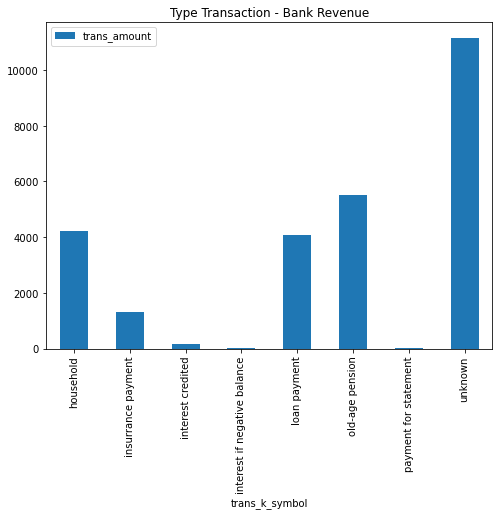

In [31]:
trans_data.pivot_table('trans_amount', 'trans_k_symbol').plot.bar(title = 'Type Transaction - Bank Revenue', figsize=(8, 6))

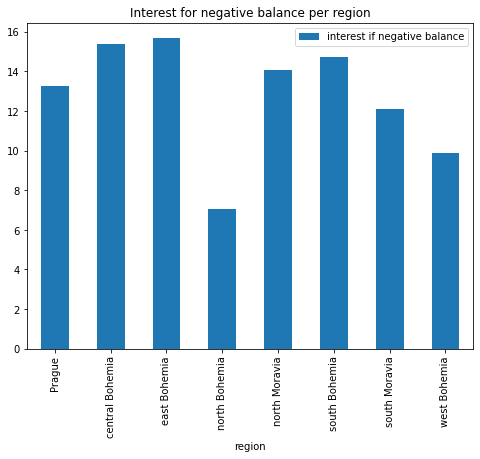

In [32]:
database.pivot_table('interest if negative balance', 'region').plot.bar( title = 'Interest for negative balance per region', figsize=(8, 6))

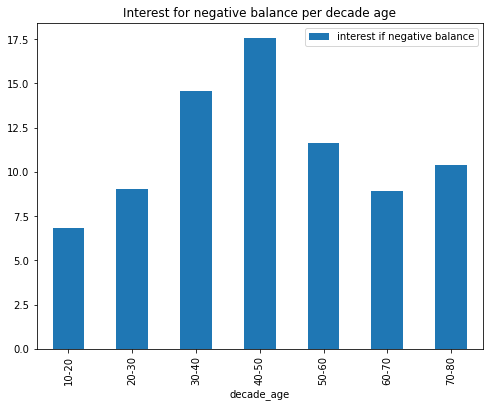

In [33]:
database.pivot_table('interest if negative balance', 'decade_age').plot.bar(title = 'Interest for negative balance per decade age', figsize=(8, 6))

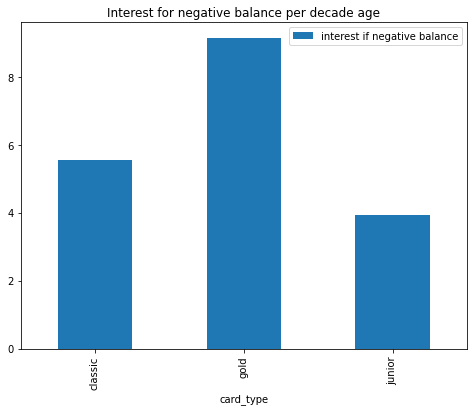

In [34]:
database.pivot_table('interest if negative balance', 'card_type').plot.bar(title = 'Interest for negative balance per decade age', figsize=(8, 6))

## Loan analysis 

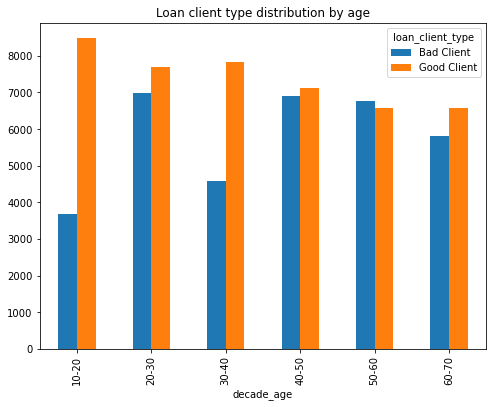

In [35]:
client_distribution = database.pivot_table('client_id', ['decade_age'], ['loan_client_type']).plot.bar(title = 'Loan client type distribution by age', figsize=(8, 6))

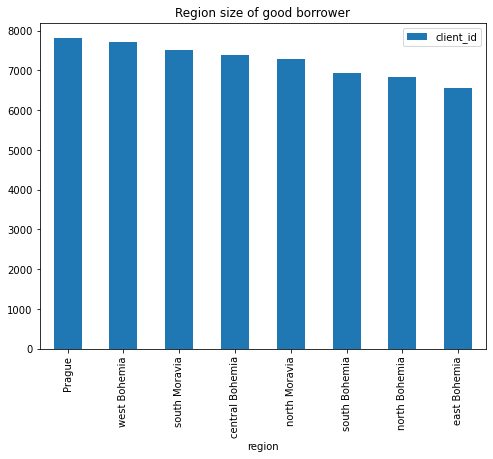

In [36]:
good_loan_client_database = database[database['loan_client_type']=='Good Client']
good_loan_client_database.pivot_table('client_id', 'region').sort_values(by='client_id', ascending=False).plot.bar(title = 'Region size of good borrower', figsize=(8, 6))

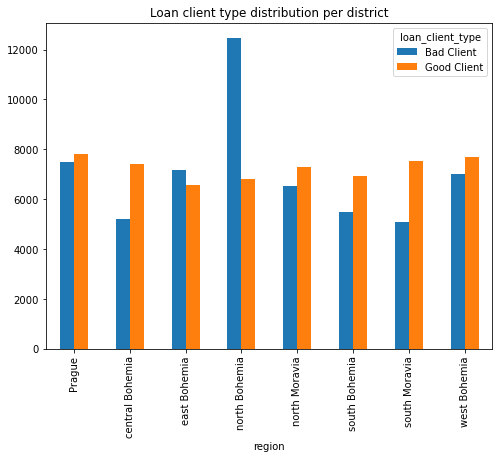

In [37]:
loan_district_distribution = database.pivot_table('client_id', 'region', 'loan_client_type').plot.bar(title = 'Loan client type distribution per district', figsize=(8, 6))

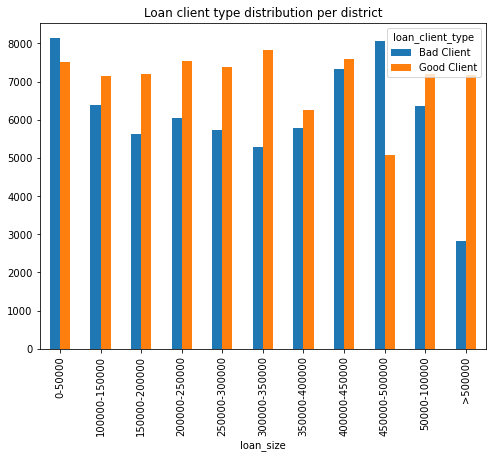

In [38]:
loan_district_distribution = database.pivot_table('client_id', 'loan_size', 'loan_client_type').plot.bar(title = 'Loan client type distribution per district', figsize=(8, 6))

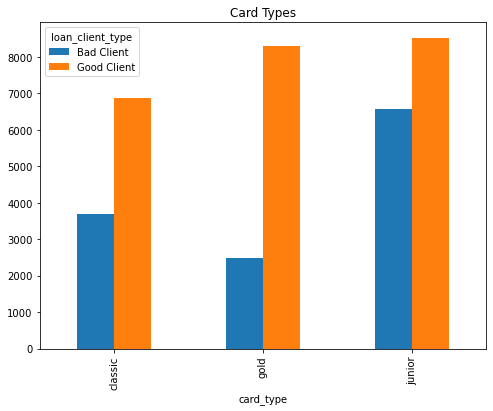

In [39]:
card_type_repartition = database.pivot_table('client_id', 'card_type', 'loan_client_type').plot.bar(title = 'Card Types', figsize=(8, 6))

In [40]:
trans_data.head()

,trans_id,account_id,trans_date,trans_type,operation,trans_amount,balance,trans_k_symbol,bank,account
0,695247,2378,1993-01-01,credit,credit in cash,700.0,700.0,unknown,NaN,NaN
1,171812,576,1993-01-01,credit,credit in cash,900.0,900.0,unknown,NaN,NaN
2,207264,704,1993-01-01,credit,credit in cash,1000.0,1000.0,unknown,NaN,NaN
3,1117247,3818,1993-01-01,credit,credit in cash,600.0,600.0,unknown,NaN,NaN
4,579373,1972,1993-01-02,credit,credit in cash,400.0,400.0,unknown,NaN,NaN


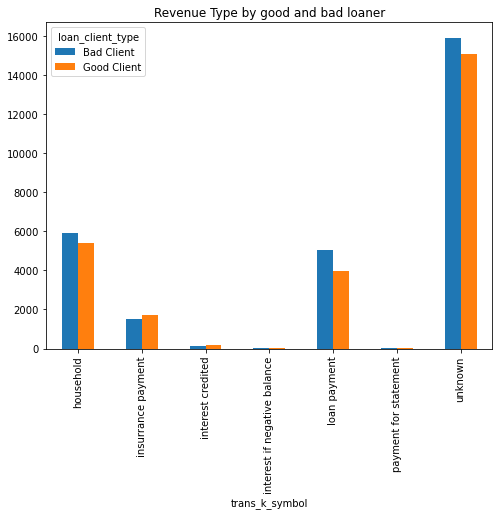

In [41]:
db = pd.merge(trans_data, account, on = 'account_id', how = 'outer')
db = pd.merge(db, loan, on = 'account_id', how = 'outer')

db.pivot_table('trans_amount','trans_k_symbol', 'loan_client_type').plot.bar(title = 'Revenue Type by good and bad loaner', figsize=(8, 6))

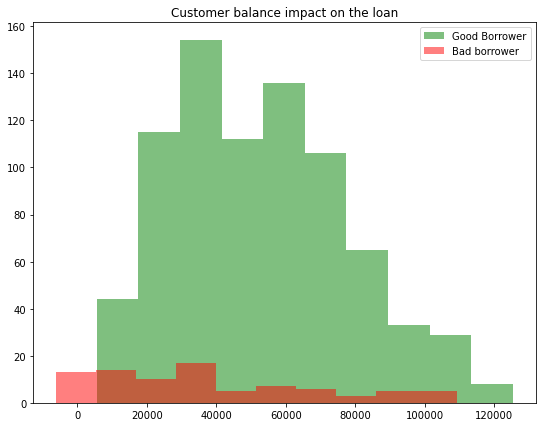

In [60]:
good_loaner = database[database['loan_client_type']=='Good Client'][['balance']].dropna().sort_values('balance').to_numpy() 
bad_loaner = database[database['loan_client_type']=='Bad Client'][['balance']].dropna().sort_values('balance').to_numpy()

plt.figure(figsize=(9, 7))
plt.hist(good_loaner, bins = 10, alpha = 0.5, color = 'green')
plt.hist(bad_loaner, bins = 10, alpha = 0.5, color = 'red')
plt.title('Customer balance impact on the loan')
plt.legend(labels=['Good Borrower', 'Bad borrower'], loc='upper right')
plt.show()

## Credit Scoring 

In [54]:
current_date = pd.to_datetime('1999-01-01')
database['seniority'] = current_date - database['account_date']
database['seniority'] = pd.to_numeric(database['seniority']/60/60/24/1000000000)
database['seniority']

senor = []

for i in database['seniority']:
    if i <0: 
        senor.append(0)
    else: 
        senor.append(i)
    
database['seniority'] = senor

In [43]:
#Coeficients
balance_coef = 0.25
loan_status_coef = 10
card_type_coef = 1
umployment_mean_coef = 1
crime_mean_coef = 0.3
seniority_coef = 1
collection_in_another_bank_coef = 0.05
old_age_pension_coef = 0.4
interest_on_negative_balance_coef = 7

In [80]:
database['loan_score'] = database['loan_client_type'].map({'Good Client':1000, 'Bad Client': -1000, np.NaN : 0})
database['card_score']= database['card_type'].map({'gold': 100, 'junior': 0, 'classic': 0, np.NaN : 0})


database.balance.fillna(0, inplace=True)
database['loan_score'].fillna(0, inplace=True)
database['card_score'].fillna(0, inplace=True)
database['unemploymant rate95'].fillna(0, inplace=True)
database['no. of commited crimes96'].fillna(0, inplace=True)
database['seniority'].fillna(0, inplace=True)
database['collection from another bank'].fillna(0, inplace=True)
database['old-age pension'].fillna(0, inplace=True)
database['interest if negative balance'].fillna(0, inplace=True)

database['client_ranking'] = round((database.balance * balance_coef 
                              + database['loan_score'] * loan_status_coef 
                              + database['card_score'] * card_type_coef
                              + database['unemploymant rate95'] * umployment_mean_coef
                              - database['no. of commited crimes96'] * crime_mean_coef
                              + database['seniority'] * seniority_coef
                              - database['collection from another bank'] * collection_in_another_bank_coef
                              + database['old-age pension'] * old_age_pension_coef
                              - database['interest if negative balance'] * interest_on_negative_balance_coef
                             ),2)
                              
                              
database = database.drop(columns =['loan_score', 'card_score'])
ranking = database[['client_id', 'client_ranking']].sort_values(by= 'client_ranking', ascending=False).drop_duplicates(subset=["client_id"], keep='last').dropna()
ranking.client_id= ranking.client_id.astype(int)
index = np.arange(1,5370)
ranking.set_index(index,inplace=True)
ranking

,client_id,client_ranking
1,2719,43159.37
2,9717,39824.12
3,9718,39724.12
4,13608,39366.28
5,10269,39045.43
...,...,...
5365,6481,-30682.16
5366,6183,-32070.61
5367,2789,-33315.96
5368,12859,-34394.26


In [ ]:
#Tentative to clean the data base and create a training set for a classifcation model 
# Delete all the transaction which the data happen after the loan data.

if db['loan_date'].item() > db['trans_date']:
    db.drop(0)
        

In [ ]:
if np.greater(db['loan_date'],db['trans_date']):
    print('Ok')